Author: Akshay Chougule

Creation Date: 09-Feb-2020

Description: This is a v4 of notebook for Human-Protein-Atlas-Competition.

Change log: The changes made wrt to the v3.5

- We try to implement focal loss

Possible thing to try next
- Try diffrent model architecture (DenseNet?)
- Move things to Jovian
- Images w/o y
- 512*512 (first train on smaller images)
- 4-channel resnet, your own resnet block
- Less frequent categories: 1. Ignore less frq cats 2. A research paper, SMOTE

In [1]:
# To deal with the  PILLOW_VERSION error. Downgrade the library
#!pip3 install Pillow==5.1

In [1]:
!pip3 show Pillow

Name: Pillow
Version: 6.1.0
Summary: Python Imaging Library (Fork)
Home-page: http://python-pillow.org
Author: Alex Clark (Fork Author)
Author-email: aclark@aclark.net
License: UNKNOWN
Location: /home/ubuntu/.local/lib/python3.6/site-packages
Requires: 


In [2]:
import pandas as pd
import wget
import time
import os
import copy

In [3]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [4]:
import fastai
from fastai.vision.image import *
from fastai.vision import *
from fastai.metrics import *
from fastai.vision import *

In [5]:
data_root = '/home/ubuntu/datasets/human-protein-atlas/'

In [6]:
train_labels = pd.read_csv(os.path.join(data_root,'train.csv'))
train_labels.head(5)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


__Create the databunch__

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
additional_aug=[*zoom_crop(scale=(0.75,1.25), do_rand=False), 
#                     brightness(scale=(0.4, 0.6)), 
#                     contrast(scale=(0.6, 1.4), p=0.75)
                   ]
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
tfms = get_transforms(dihedral_affine(),max_lighting=0.2, max_zoom=1.15, xtra_tfms=additional_aug)

In [9]:
test = ImageList.from_csv(data_root,'sample_submission.csv',folder='test_512by512',suffix='.png')

In [10]:
src = (ImageList.from_csv(data_root,'train.csv',folder='train_512by512',suffix='.png')
        .split_by_rand_pct(0.2)
        .label_from_df(cols='Target',label_delim=' ')
       .add_test(test))

In [11]:
src.train.databunch

<bound method LabelList.databunch of LabelList (24858 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
7;1;2;0,1,18,25;2,0
Path: /home/ubuntu/datasets/human-protein-atlas>

In [12]:
src.valid.databunch

<bound method LabelList.databunch of LabelList (6214 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
2;0,23,25;2,19;0,8
Path: /home/ubuntu/datasets/human-protein-atlas>

In [13]:
src.test.databunch

<bound method LabelList.databunch of LabelList (11702 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: EmptyLabelList
,,,,
Path: /home/ubuntu/datasets/human-protein-atlas>

^ that looks correct. We have 80% of the images in train and 20% in validation databunch as specified. Alos the test data count match.

In [14]:
data = (src.transform(tfms, size=224)
        .databunch(bs = 8).normalize(imagenet_stats))

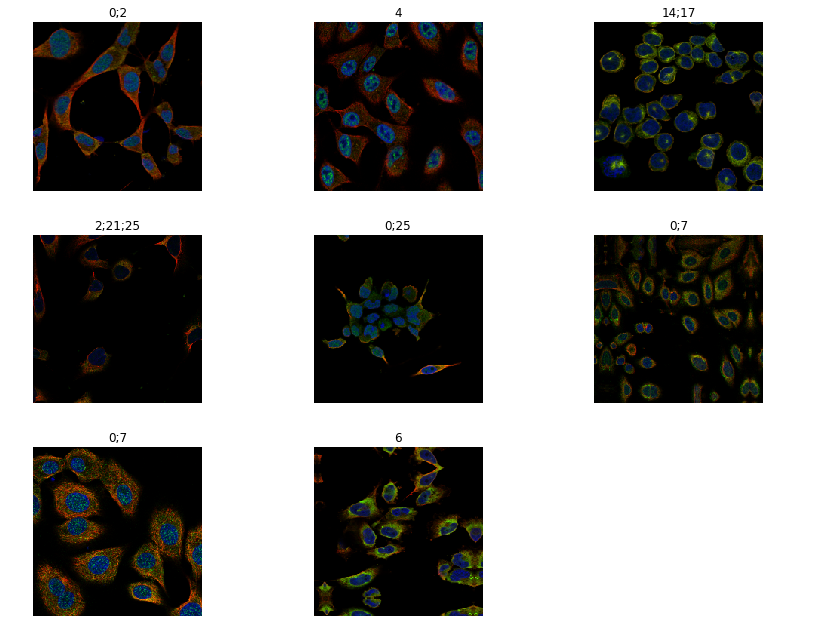

In [15]:
data.show_batch(rows=3, figsize=(12,9))

In [23]:
# method 1: from kornia  // Did NOT work. Seems for single class classification
# from kornia.losses import focal
# FC = focal.FocalLoss(alpha= 0.5, gamma=2.0)

In [93]:
# method 2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)
        print(len(target))
        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [61]:
# Method 3: From kaggle:https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.long() , reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets.long() , reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [194]:
yt = torch.zeros([8, 28])
yp = torch.zeros([8, 28])

In [220]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

In [361]:
# method 4 : https://colab.research.google.com/drive/1NiUwI6ohF1b9TthutyfJQnOJ2i39R5cJ#scrollTo=qo8kiV3mtC-S

def focal_loss(y_pred,y_true,alpha=0.25,gamma=2,):
    
    #alpha=0.25,gamma=2
    if isinstance(alpha,(list,tuple)):
        fore_alpha = alpha[0] # postive sample ratio in the entire dataset
        back_alpha = alpha[1] #(1-alpha) # negative ratio in the entire dataset
    elif isinstance(alpha ,(int,float)):
        fore_alpha = alpha
        back_alpha = (1-alpha)
        
    n_positives = (y_true!=0).sum() # all postive anchors for 28 class
    
    #print(y_true.size())
    #print(type(y_true))
    #y_true = y_true.long()
    #print(y_true)
    #y_true = torch.eye(y_pred.shape[-1])[y_true].cuda() # one hot vector for all prediction
    #print(y_true)
    y_pred = F.softmax(y_pred,dim=1) # apply softmax
    
    #print(y_pred.size())
    
    y_true = y_true.to('cuda')
    
    #yt = y_true
    #yp = y_pred
    
    
    # in the dataset background classes is taken in the front so 1 background class + 27 classes = 28 classes
    back_pred = y_pred[:,0:1] # 1st column background
    fore_pred = y_pred[:,1:]  # 20 columns foreground
    back_true = y_true[:,0:1]  # 1st column background
    fore_true = y_true[:,1:] # 20 columns foreground
    
    #print('Size of back_pred'+  str(back_pred.size()) + '  Size of fore_pred' + str(fore_pred.size()))
    #print('Size of back_true'+  str(back_true.size()) + '  Size of fore_true' + str(fore_true.size()))
    
    #print(back_true.size(),back_alpha,fore_true.size(),fore_alpha)
    alpha_factor = torch.cat([ back_true *back_alpha ,  fore_true * fore_alpha],dim=1)  ## alpha factor 
         
    #print(back_true.size(),back_pred.size(),fore_true.size(),fore_pred.size())
    #print(back_true.size(),back_pred.size(),fore_true.size(),fore_pred.size())
    focal_weight = torch.cat([ back_true * back_pred , fore_true * (1-fore_pred) ] ,dim=1) #because background is also a class so (1-back_true) will lead to false output
    fc1 = back_true * back_pred 
    #print(fc1.size())
    #print('Size of fore_true'+  str(fore_true.size()) + '  Size of fore_pred' + str(fore_pred.size()))
    fc2 = fore_true * (fore_pred)
    #print(fc2.size())
    
    cross_entropy = -1 *  torch.log(y_pred) # normal cross entropy
    
    focal_weight = focal_weight.to('cuda')
    #gamma = gamma.to('cuda')
    cross_entropy = cross_entropy.to('cuda')
    alpha_factor = alpha_factor.to('cuda')
    
    loss =  alpha_factor * (focal_weight ** gamma) * cross_entropy # focal loss with modulating factor
    
    # normalize the loss with positive anchors
    return loss.sum()/n_positives  # if want to use it for anything else other then SSD use loss = loss.sum()/len(y_pred)

In [362]:
# method 5: the creator's code
# source: https://github.com/kuangliu/pytorch-retinanet/blob/master/loss.py
# did a wget and renamed as focal_loss
# import focal_loss

In [379]:
arch = models.resnet18
#FC = FocalLoss()
#fc = partial(focal_loss, gamma=2.0, alpha=0.25)
F1 = MultiLabelFbeta(beta=2, average="macro")

In [380]:
setattr(src, 'device', 'cuda') 
#setattr(FocalLoss, 'func', 'NA') 

In [381]:
# to get the v3.5 results w resnet 34
#learn.load('nb-v3-resnet34-stage2-F1-macro')

In [382]:
learn = cnn_learner(data, arch, metrics=F1)

In [383]:
learn.loss_func=focal_loss#fc
# learn.loss_func=FocalLoss(alpha= 0.5, gamma=2.0)
# learn.loss_func=focal.FocalLoss(alpha= 0.5, gamma=2.0)

In [384]:
learn.data.batch_size

8

In [385]:
learn.lr_find()

epoch,train_loss,valid_loss,multi_label_fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [269]:
# torch.Size([8, 1, 28]) torch.Size([8, 1]) 
tt1 = torch.zeros([8, 1, 28])
tt2 = torch.zeros([8, 1])
tt3=tt1*tt2

In [311]:
# Size of fore_truetorch.Size([8, 27, 28])  Size of fore_predtorch.Size([8, 27])
tt1 = torch.zeros([8, 27, 28])
tt2 = torch.zeros([8, 27])

In [370]:
#tt1*tt2

In [205]:
y_pred = yp
y_true = yt

In [206]:
# in the dataset background classes is taken in the front so 1 background class + 20 classes = 21 classes
y_pred

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [207]:
# in the dataset background classes is taken in the front so 1 background class + 27 classes = 28 classes
back_pred = y_pred[:,0:1] # 1st column background
fore_pred = y_pred[:,1:]  # 27columns foreground
back_true = y_true[:,0:1]  # 1st column background
fore_true = y_true[:,1:] # 27columns foreground

In [213]:
alpha=0.25
gamma=2
if isinstance(alpha,(list,tuple)):
    fore_alpha = alpha[0] # postive sample ratio in the entire dataset
    back_alpha = alpha[1] #(1-alpha) # negative ratio in the entire dataset
elif isinstance(alpha ,(int,float)):
    fore_alpha = alpha
    back_alpha = (1-alpha)

In [214]:
#print(back_true.size(),back_alpha,fore_true.size(),fore_alpha)
alpha_factor = torch.cat([ back_true *back_alpha ,  fore_true * fore_alpha],dim=1)  ## alpha factor 
alpha_factor

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [216]:
focal_weight = torch.cat([ back_true * back_pred , fore_true * (1-fore_pred) ] ,dim=1) #because background is also a class so (1-back_true) will lead to false output
focal_weight

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [217]:
cross_entropy = -1 *  torch.log(y_pred) # normal cross entropy
loss =  alpha_factor * (focal_weight ** gamma) * cross_entropy # focal loss with modulating factor

In [219]:
cross_entropy

tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
         inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, in

In [218]:
loss

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, na

In [ ]:
print(back_true.size(),back_pred.size(),fore_true.size(),fore_pred.size())
#focal_weight = torch.cat([ back_true * back_pred , fore_true * (1-fore_pred) ] ,dim=1) #because background is also a class so (1-back_true) will lead to false output
#fc1 = back_true * back_pred 
print('Size of fore_true'+  str(fore_true.size()) + '  Size of fore_pred' + str(fore_pred.size()))
fc2 = fore_true * (1-fore_pred)
print(fc2)

cross_entropy = -1 *  torch.log(y_pred) # normal cross entropy
loss =  alpha_factor * (focal_weight ** gamma) * cross_entropy # focal loss with modulating factor

# normalize the loss with positive anchors
return loss.sum()/n_positives  # if want to use it for anything else other then SSD use loss = loss.sum()/len(y_pred)

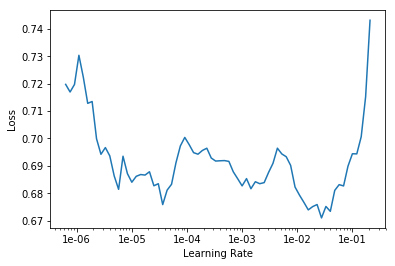

In [386]:
learn.recorder.plot()

In [387]:
lr = 0.0001

In [ ]:
# I belive this was run after stage 1 (5 epochs) and stage 2 (10 epochs), model save, model load, then these 5 epochs.
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.544374,0.474702,0.187918,01:15


In [374]:
learn.save('nb-v4-resnet34-stage1-F1-macro')

In [375]:
learn.unfreeze()

epoch,train_loss,valid_loss,multi_label_fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


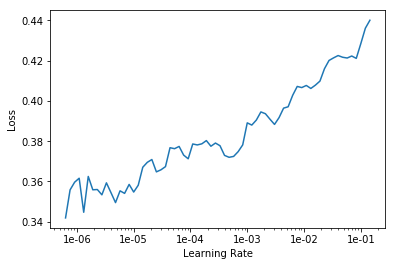

In [376]:
learn.lr_find()
learn.recorder.plot()

In [377]:
learn.fit_one_cycle(10, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.347240,nan,0.234416,01:28
1,0.369599,nan,0.226785,01:29
2,0.351015,nan,0.219812,01:30
3,0.332075,nan,0.222383,01:30


KeyboardInterrupt: 

In [38]:
learn.save('nb-v4-resnet34-stage2-F1-macro')

In [30]:
# This was saved at the end of v3. What we see above is v3.5
# learn.save('nb-v3-resnet34-stage2-F1-macro')

In [23]:
#learn.load('nb-v3-resnet34-stage2-F1-macro')

### Testing the data

__Making the predictions__

In [29]:
preds, _ = learn.get_preds(DatasetType.Test)

fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_512by512/','')
sample_submission = pd.read_csv(data_root+'sample_submission.csv')

In [27]:
learn.data.test_ds.items

array(['/home/ubuntu/datasets/human-protein-atlas/test_512by512/00008af0-bad0-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/0000a892-bacf-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/0008baca-bad7-11e8-b2b9-ac1f6b6435d0.png', ...,
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/ffdfc590-bad4-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/ffecb8a4-bad4-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/fff03816-bad5-11e8-b2b9-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/fffe6f9c-bacd-11e8-b2b8-ac1f6b6435d0.png'],
      dtype='<U96')

Let's try playing around with the threshold

In [31]:
thresholds = [0.18,0.16,0.14,0.12,0.10]

for thresh in thresholds:
    labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
    fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_512by512/','')
    df = pd.DataFrame({'Id':fnames, 'Predicted':labelled_preds}, columns=['Id', 'Predicted'])
    df2 = pd.merge(sample_submission['Id'], df, on='Id', how='left')
    df2.to_csv('protein_classification_nb-V3.5_stage2_thresh_'+str(thresh)+'.csv', header=True, index=False)

In [32]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V3.5_stage2_thresh_0.18.csv -m "Model v3.5 with resnet18 stage-2 and thrsd 0.18"

100%|█████████████████████████████████████████| 486k/486k [00:00<00:00, 591kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [33]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V3.5_stage2_thresh_0.16.csv -m "Model v3.5 with resnet18 stage-2 and thrsd 0.16"

100%|█████████████████████████████████████████| 490k/490k [00:00<00:00, 669kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [34]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V3.5_stage2_thresh_0.14.csv -m "Model v3.5 with resnet18 stage-2 and thrsd  0.14"

100%|█████████████████████████████████████████| 494k/494k [00:00<00:00, 638kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [35]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V3.5_stage2_thresh_0.12.csv -m "Model v3.5 with resnet18 stage-2 and thrsd 0.12"

100%|█████████████████████████████████████████| 500k/500k [00:00<00:00, 617kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [36]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V3.5_stage2_thresh_0.1.csv -m "Model v3.5 with resnet18 stage-2 and thrsd  0.1"

100%|█████████████████████████████████████████| 507k/507k [00:00<00:00, 866kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [37]:
!kaggle competitions submissions -c human-protein-atlas-image-classification > results.txt
!cat results.txt

fileName                                               date                 description                                       status    publicScore  privateScore  
-----------------------------------------------------  -------------------  ------------------------------------------------  --------  -----------  ------------  
protein_classification_nb-V3.5_stage2_thresh_0.1.csv   2020-02-09 18:01:08  Model v3.5 with resnet18 stage-2 and thrsd  0.1   complete  0.38798      0.39202       
protein_classification_nb-V3.5_stage2_thresh_0.12.csv  2020-02-09 18:01:05  Model v3.5 with resnet18 stage-2 and thrsd 0.12   complete  0.39374      0.39745       
protein_classification_nb-V3.5_stage2_thresh_0.14.csv  2020-02-09 18:01:03  Model v3.5 with resnet18 stage-2 and thrsd  0.14  complete  0.39649      0.40267       
protein_classification_nb-V3.5_stage2_thresh_0.16.csv  2020-02-09 18:01:00  Model v3.5 with resnet18 stage-2 and thrsd 0.16   complete  0.40003      0.40452       
protein_classifi